In [2]:
import torch
from accuracy import Accuracy
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from utils.vis import *
from utils.data import *
from model import PoseModel
from transform import *
from dataset import PlanktonDataset
import cPickle as pickle
import numpy as np
import glob
%matplotlib inline

In [3]:
img_dir = '/data5/Plankton_wi18/rawcolor_db/images'
csv_filename = '/data5/lekevin/plankton/poseprediction/data/data_{}.csv'

phases = ['train', 'valid', 'test']

# dataset_mean, dataset_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
normalize = Normalize([0.5, 0.5, 0.5], [1, 1, 1])

batch_size = 16

input_size = (384, 384)

_GPU = 1

data_transform = {
    'train': transforms.Compose([
        Rescale(input_size),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        ToTensor(),
        normalize
    ]),
    'valid': transforms.Compose([
        Rescale(input_size),
        ToTensor(),
        normalize
    ]),
    'test': transforms.Compose([
        Rescale(input_size),
        ToTensor(),
        normalize
    ])
}
print 'Loading datasets ...'
datasets = {x: PlanktonDataset(csv_file=csv_filename.format(x),
                               img_dir=img_dir,
                               transform=data_transform[x])
            for x in phases}

dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size,
                             shuffle=False, num_workers=4)
               for x in phases}

dataset_sizes = {x: len(datasets[x]) for x in phases}

use_gpu = torch.cuda.is_available()

Loading datasets ...


In [6]:
predCoordinates = pickle.load(open('predPose.p', "rb"))
predCoordinates = np.asarray([np.fliplr(i) for i in predCoordinates]) # (y,x) --> (x,y)
# taxLvl Datasets Order --> Specimen, Genus, Family, Order, Dataset
headX, headY = datasets['test'].data['head_x_rel'], datasets['test'].data['head_y_rel']
tailX, tailY =  datasets['test'].data['tail_x_rel'], datasets['test'].data['tail_y_rel']
testTaxLvlDatasets, testspecimenIDs = group_specimen2class(datasets['test'].data['images'])
trainTaxLvlDatasets, trainspecimenIDs = group_specimen2class(datasets['train'].data['images'])
#TODO setup group_specimen2class into dictionary

In [29]:
specimenSet = testTaxLvlDatasets[2]
classMetrics, classMetrics_idx = {}, {}
for cls in specimenSet:
    #print "="*10, '\n', cls
    idx = [i for i, spc in enumerate(testspecimenIDs) if spc in specimenSet[cls]]
    accuracyEval = Accuracy (headX[idx], headY[idx], tailX[idx], tailY[idx])
    classMetrics[cls] = accuracyEval.euclideanDistance (predCoordinates[idx])
    classMetrics_idx[cls] = idx
    #print "Head Distance: {}".format(classMetrics[cls][0])
    #print "Tail Distancce: {}".format (classMetrics[cls][1])
    #print "Average Distance: {}".format (classMetrics[cls][2])

In [12]:
classMetrics['Dataset'][3].keys()

['Head Distribution', 'Tail Distribution']

Average Euclidian Distance:  0.10655394637052765


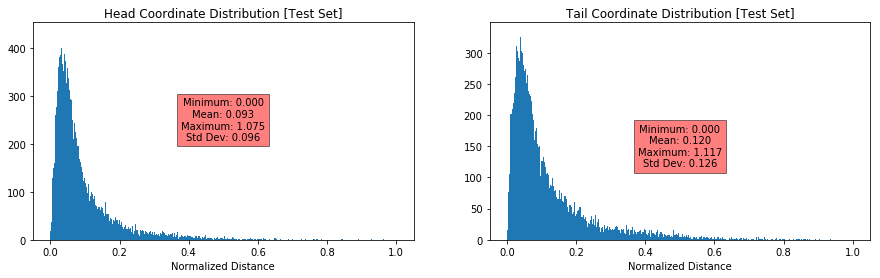

In [24]:
headEuclid = classMetrics['Dataset'][3]['Head Distribution']
tailEuclid = classMetrics['Dataset'][3]['Tail Distribution']
fig, axarr = plt.subplots(1,2, figsize=(15,4))
hn, hbins, hpatches = axarr[0].hist(headEuclid, 500, range=[0.0, 1.0])
axarr[0].set_xlabel('Normalized Distance')
axarr[0].set_title('Head Coordinate Distribution [Test Set]')
axarr[0].text(0.5,250, 'Minimum: {:0.3f}\nMean: {:0.3f}\nMaximum: {:0.3f}\nStd Dev: {:0.3f}'.format(headEuclid.min(), headEuclid.mean(),
              headEuclid.max(), np.std(headEuclid)),
              bbox=dict(facecolor='red', alpha=0.5),  horizontalalignment='center', verticalalignment='center')

tn, tbins, tpatches = axarr[1].hist(tailEuclid, 500, range=[0.0, 1.0])
axarr[1].set_xlabel('Normalized Distance')
axarr[1].set_title('Tail Coordinate Distribution [Test Set]')
axarr[1].text(0.5,150, 'Minimum: {:0.3f}\nMean: {:0.3f}\nMaximum: {:0.3f}\nStd Dev: {:0.3f}'.format(tailEuclid.min(), tailEuclid.mean(),
              tailEuclid.max(), np.std(tailEuclid)),
              bbox=dict(facecolor='red', alpha=0.5),  horizontalalignment='center', verticalalignment='center')
print 'Average Euclidian Distance: ', 0.5*(headEuclid.mean() + tailEuclid.mean())

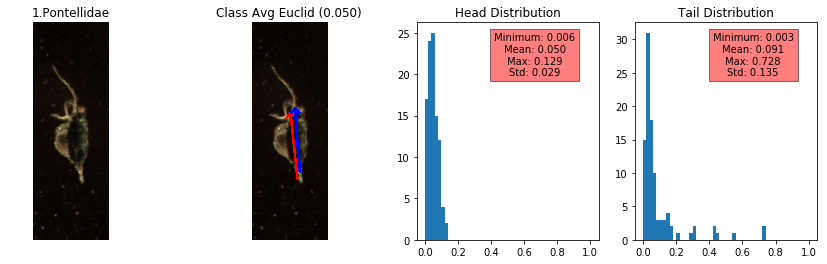

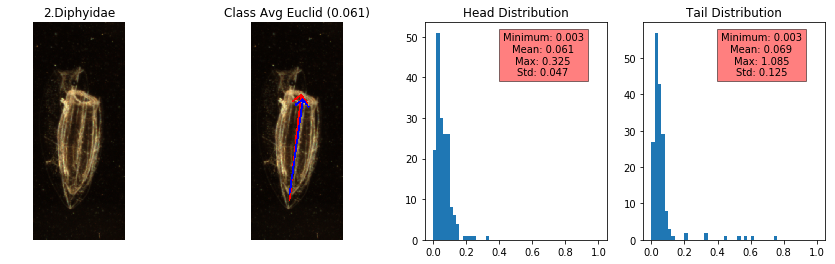

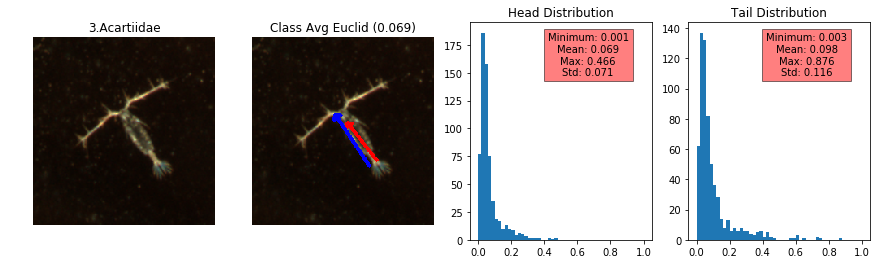

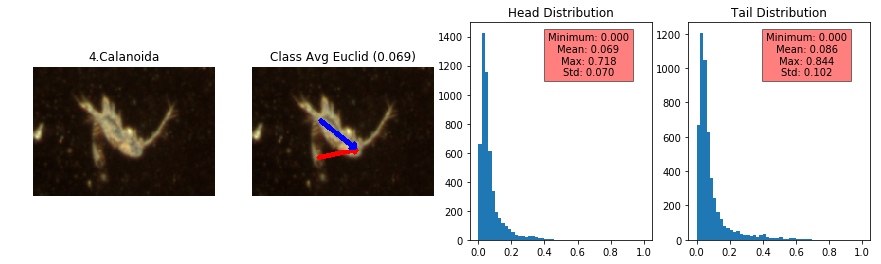

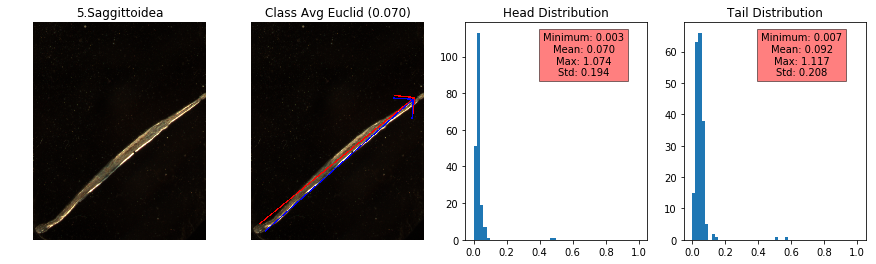

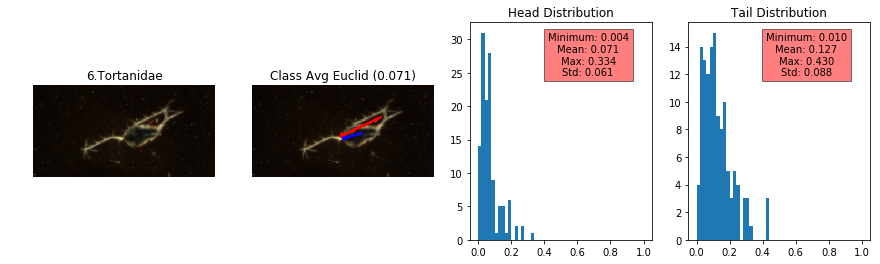

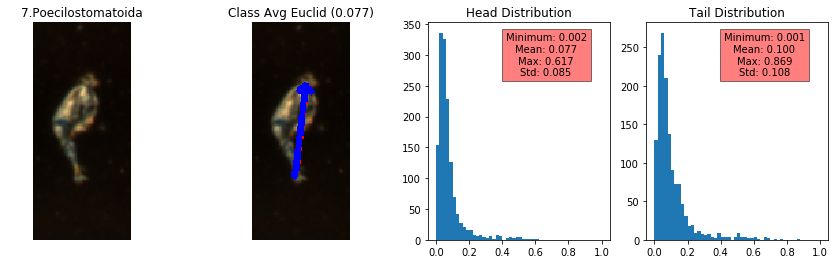

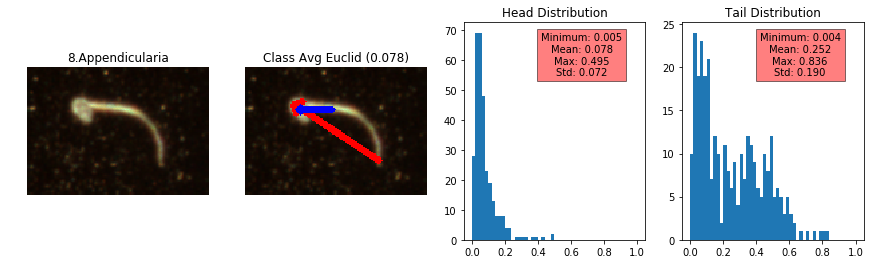

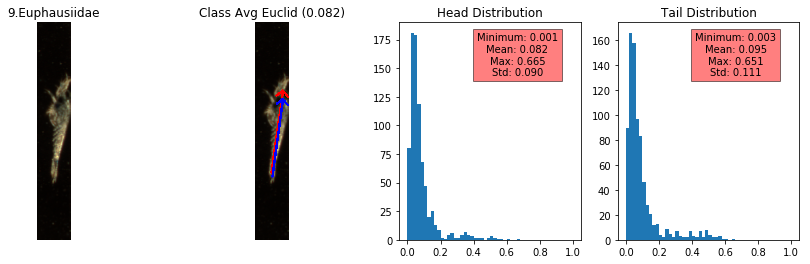

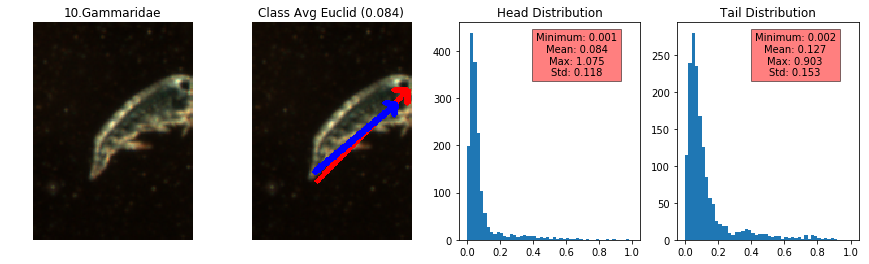

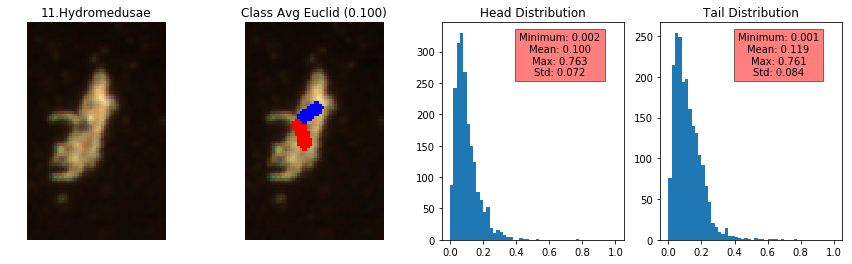

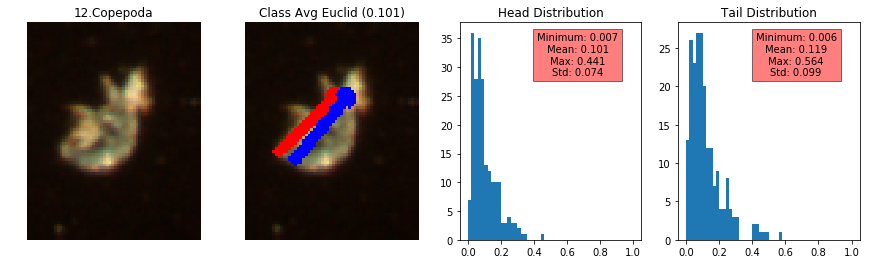

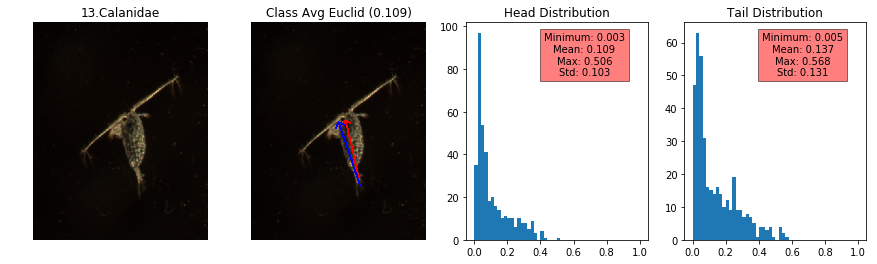

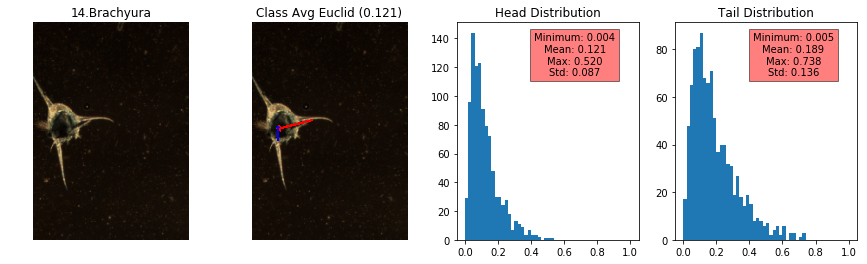

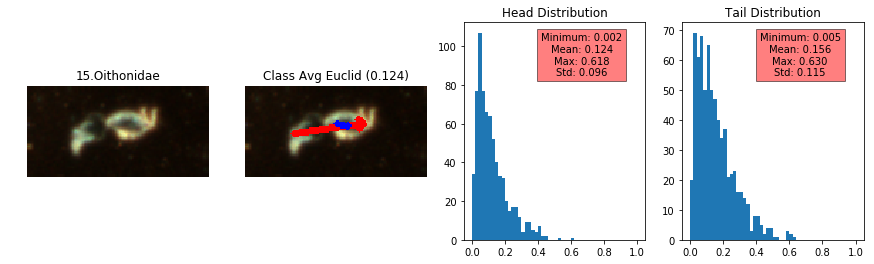

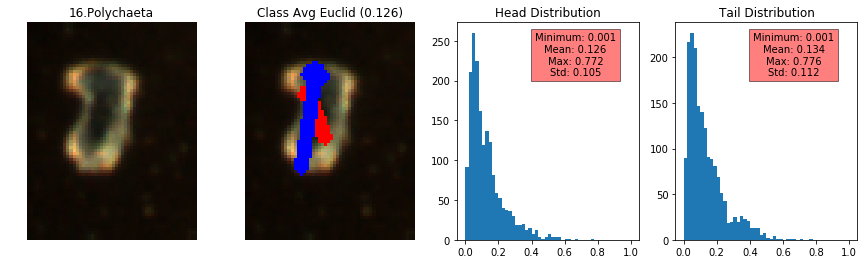

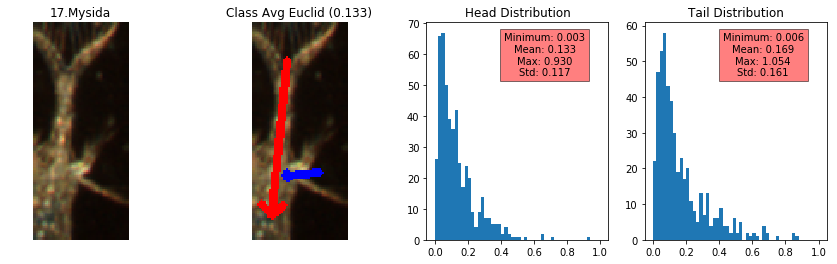

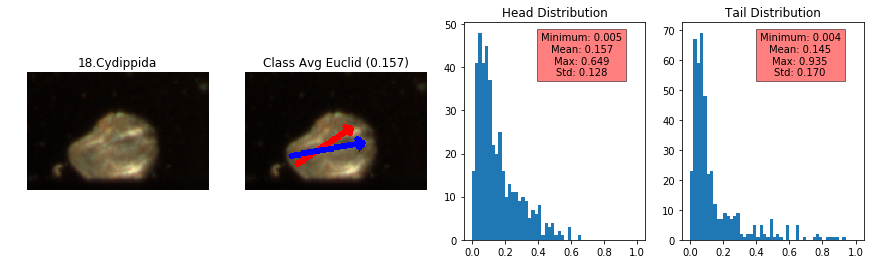

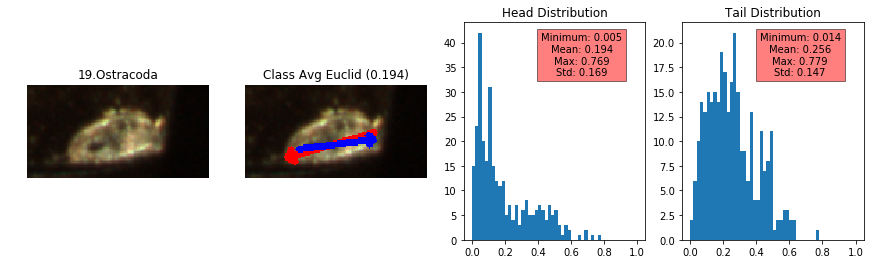

In [41]:
def plotEuclidDistribution(clsMetrics, clsMetIdx, dataset, predCoordinates):
    img_dir = '/data5/Plankton_wi18/rawcolor_db/images'
    numCols = 4
    avgEuclid = 2
    histData = 3

    # Order classes
    classes = clsMetrics.keys()
    order = np.argsort([clsMetrics[cls][avgEuclid] for cls in classes])
    classes = [classes[i] for i in order]

    #plot Distributions
    for j,cls in enumerate(classes):
        fig, axarr = plt.subplots(1, numCols, figsize=(15,4))
        idx = clsMetIdx[cls][0] # image sample
        img = plt.imread(os.path.join(img_dir,dataset.data['images'][idx]))
        axarr[0].imshow(img)
        axarr[0].set_axis_off()
        axarr[0].set_title('{}.{}'.format(j+1, cls.split()[0]))
        
        headX, headY = dataset.data['head_x_rel'][idx], dataset.data['head_y_rel'][idx]
        tailX, tailY =  dataset.data['tail_x_rel'][idx], dataset.data['tail_y_rel'][idx]
        plotArrow(img, predCoordinates[idx], np.array([headX, headY, tailX, tailY]))
        axarr[1].imshow(img)
        axarr[1].set_axis_off()
        axarr[1].set_title('Class Avg Euclid ({:.03f})'.format(clsMetrics[cls][avgEuclid]))
        for i,part in enumerate(clsMetrics[cls][histData]):
            clsMin, clsMean, clsMax, clsStd = euclidStats(clsMetrics[cls][histData][part])
            axarr[i+2].hist(clsMetrics[cls][histData][part], 50, range=[0.0, 1.0])
            axarr[i+2].set_title(part)
            axarr[i+2].text(0.65,0.85, 'Minimum: {:0.3f}\nMean: {:0.3f}\nMax: {:0.3f}\nStd: {:0.3f}'.format(clsMin, clsMean, clsMax, clsStd), bbox=dict(facecolor='red', alpha=0.5),
                            horizontalalignment='center', verticalalignment='center', transform=axarr[i+2].transAxes)
    plt.show()
    
def plotArrow(image, predcoordinates, gtruthcoordinates):
    height, width = image.shape[:2]
    predhead = (int(predcoordinates[0,0] * width), int(predcoordinates[0,1]*height))
    predtail = (int(predcoordinates[1,0] * width), int(predcoordinates[1,1]*height))

    gtruthhead = (int(gtruthcoordinates[0] * width), int(gtruthcoordinates[1] * height))
    gtruthtail = (int(gtruthcoordinates[2] * width), int(gtruthcoordinates[3] * height))
    cv2.arrowedLine(image, gtruthtail, gtruthhead, (1., 0., 0.), 3) # gtruth
    cv2.arrowedLine (image, predtail, predhead, (0., 0., 1.), 3) # prediction

def euclidStats(histData):
    if not isinstance(histData, np.ndarray):
        histData = np.asarray(histData)
    return histData.min(), histData.mean(), histData.max(), np.std(histData)

plotEuclidDistribution(classMetrics, classMetrics_idx, datasets['test'], predCoordinates)